In [1]:
import torch         # Base PyTorch library for tensor operations.
import torch.nn as nn
import torch.nn.functional as F       # Contains activation functions (e.g., `elu`, `log_softmax`) and loss functions (e.g., `nll_loss`).
from torch_geometric.datasets import Planetoid           # Downloads standard citation network datasets (Cora, Citeseer, Pubmed)
from torch_geometric.transforms import NormalizeFeatures # Normalizes node features to sum to 1 (helps training)
from torch_geometric.nn import GATConv                   # Pre-built GAT layer from PyTorch Geometric.
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
# 1. Download and preprocess data

# Device Configuration - Purpose: Use GPU if available for faster training.
"""
   torch.cuda.is_available(): Checks if CUDA-enabled GPU is available
   device variable: Will be either 'cuda' (GPU) or 'cpu' (CPU)
"""

device  = 'cuda' if torch.cuda.is_available() else 'cpu'
    
# Load Cora dataset with normalized features
"""
     root: Directory where dataset will be stored/downloaded
     name='Cora': Specifies the Cora dataset (citation network)
     transform=NormalizeFeatures(): Applies feature normalization

    dataset[0]: Accesses the first (and only) graph in the dataset
    .to(device): Moves all tensors (features, edges, etc.) to GPU/CPU
"""
dataset = Planetoid(root='C:/Users/Majid/Downloads/CNN', name='Cora', transform=NormalizeFeatures())
data = dataset[0].to(device)  # Move graph data to GPU/CPU
    
# Print dataset info
print(f"Dataset: {dataset}")
print(f"First 5 nodes features : {data.x[:5]}\n")
print(f"First 5 edges: {data.edge_index[:5]}\n")
print(f"First 5 labels: {data.y[:5]}\n")
print(f"First 5 test mask: {data.test_mask[:5]}")
print(f"First 5 train mask: {data.train_mask[:5]}")
print(f"First 5 validation mask: {data.val_mask[:5]}")
   
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")

"""
    data: The complete graph object containing:
       - Node features (data.x)
       - Edge indices (data.edge_index)
       - Labels (data.y)
       - Train/val/test masks (data.train_mask, etc.)
    dataset.num_features: Number of input features per node (1,433)
    dataset.num_classes: Number of output classes (7)
 """

Dataset: Cora()
First 5 nodes features : tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

First 5 edges: tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
        [   0,    0,    0,  ..., 2707, 2707, 2707]])

First 5 labels: tensor([3, 4, 4, 0, 3])

First 5 test mask: tensor([False, False, False, False, False])
First 5 train mask: tensor([True, True, True, True, True])
First 5 validation mask: tensor([False, False, False, False, False])
Number of nodes: 2708
Number of edges: 10556
Number of features: 1433
Number of classes: 7


'\n    data: The complete graph object containing:\n       - Node features (data.x)\n       - Edge indices (data.edge_index)\n       - Labels (data.y)\n       - Train/val/test masks (data.train_mask, etc.)\n    dataset.num_features: Number of input features per node (1,433)\n    dataset.num_classes: Number of output classes (7)\n '

In [3]:
# Step 2: Define GAT model
class GAT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        """
           # Input: `dataset.num_features` (1,433-dimensional word counts).
           # Applies attention mechanism with 8 heads.
           # Output: 8 features per head × 8 heads = 64 total features.
           # dropout=0.6`: Drops 60% of attention weights during training for regularization.
        """
        self.conv1 = GATConv(dataset.num_features, 8, heads=8, dropout=0.6)
        """
            Input: 64 features (from previous layer).
            Output: `dataset.num_classes` (7 paper categories).
            Single attention head (standard for final classification).
        """
        self.conv2 = GATConv(8 * 8, dataset.num_classes, heads=1, dropout=0.6)
        
    def forward(self, x, edge_index):

        """
            Input Dropout: Drops 60% of input features.
            Applies attention mechanism with 8 heads.
            Uses ELU activation: `elu(x) = x if x > 0 else α(e^x - 1)` (smoother than ReLU).
        """
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        
        """
            Hidden Dropout: Drops 60% of the first layer's outputs.
            Second GAT Layer: Produces log probabilities for each class via `log_softmax`.
        """
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [4]:
# Step 3: Initialize model and optimizer

"""
   Device: Uses GPU if available.
   optimizer: Adam optimizer with:
   Learning rate (lr=0.005) - Typical (0.001) 
   Weight decay (5e-4) - L2 regularization to prevent overfitting
   criterion: CrossEntropyLoss - Standard for multi-class classification
"""

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

In [5]:
# Step 4: Training function
def train():
    # Sets model to training mode (important for dropout/batch norm if used)
    model.train()    

    # Resets gradients from previous iteration
    optimizer.zero_grad()   
    
    # Calls the forward method of GATModel
    # Input: Node features (data.x) and graph structure (data.edge_index)
    # Output: Class predictions for all nodes
    out = model(data.x, data.edge_index)

    #  Computed only on training nodes (data.train_mask)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])

    # Computes gradients via backpropagation
    loss.backward()

    # Updates model parameters using gradients
    optimizer.step()
    
    return loss.item()

In [6]:
# 4. Prediction and evaluation
def test():

    """ Puts the model in evaluation mode
        Disables dropout and batch normalization layers if present
        Ensures consistent behavior during inference
    """
    model.eval()

    """ Runs the forward pass of the model
        Inputs: 
             data.x: Node feature matrix (shape: [num_nodes, num_features]) 
             data.edge_index: Graph connectivity (shape: [2, num_edges])
        data.edge_index: Graph connectivity (shape: [2, num_edges])
    """
    out = model(data.x, data.edge_index)

    """
       Converts logits to predicted class labels
       argmax(dim=1) selects the class with highest score for each node
       Result is a tensor of predicted class indices (shape: [num_nodes])
    """
    pred = out.argmax(dim=1)
    
    # Accuracy Calculation
    """
       Sums correct predictions (train_correct.sum())
       Divides by total nodes in split (train_mask.sum())
       Converts to Python int to avoid tensor types
       Results are floating-point accuracy values between 0 and 1
    """
    train_correct = pred[data.train_mask] == data.y[data.train_mask]
    val_correct = pred[data.val_mask] == data.y[data.val_mask]
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    
    train_acc = int(train_correct.sum()) / int(data.train_mask.sum())
    val_acc = int(val_correct.sum()) / int(data.val_mask.sum())
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    
    return train_acc, val_acc, test_acc

In [7]:
# Training loop
# Runs for 100 complete passes through the dataset
losses = []
for epoch in range(100):
    
    """
       Call train() function:
           Sets model to training mode (model.train())
           Performs forward pass to compute predictions
           Calculates loss on training nodes
           Calculates loss on training nodes
           Updates model parameters (optimizer.step())
           Updates model parameters (optimizer.step())
    """
    loss = train()
    losses.append(loss)

    """
        Calls test() function which:
            Sets model to evaluation mode (model.eval())
            Computes predictions on all data
            Computes predictions on all data
            
    """
    if epoch % 10 == 0:
        train_acc, val_acc, test_acc = test()
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
              f'Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 000, Loss: 1.9477, Train: 0.5286, Val: 0.3760, Test: 0.3940
Epoch: 010, Loss: 1.8831, Train: 0.9214, Val: 0.6820, Test: 0.6940
Epoch: 020, Loss: 1.7889, Train: 0.9571, Val: 0.7940, Test: 0.8020
Epoch: 030, Loss: 1.6616, Train: 0.9500, Val: 0.7700, Test: 0.7690
Epoch: 040, Loss: 1.5591, Train: 0.9571, Val: 0.7880, Test: 0.7900
Epoch: 050, Loss: 1.4631, Train: 0.9571, Val: 0.8040, Test: 0.8100
Epoch: 060, Loss: 1.2722, Train: 0.9786, Val: 0.8140, Test: 0.8190
Epoch: 070, Loss: 1.1277, Train: 0.9571, Val: 0.7960, Test: 0.8030
Epoch: 080, Loss: 1.0608, Train: 0.9714, Val: 0.8040, Test: 0.8030
Epoch: 090, Loss: 0.9501, Train: 0.9857, Val: 0.7980, Test: 0.8020


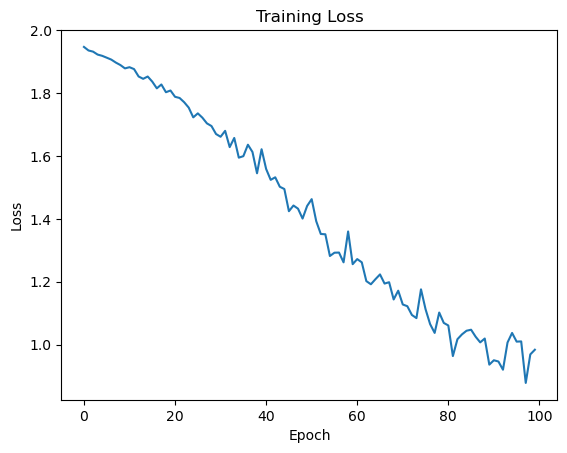

In [8]:
# Plot training loss
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [9]:
# Final evaluation
train_acc, val_acc, test_acc = test()
print(f'Final results: Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Final results: Train: 0.9786, Val: 0.8100, Test: 0.8120
